#Practical session Artificial Intelligence: Neural Networks

Assistants: Angel Lopez, Laurens Meeus, Nina Žižakić

Professor: Aleksandra Pižurica

## global settings

Make sure to set in *Runtime > Change runtime type*, *hardware accelerator* to *GPU* for faster processing


In [0]:
group_number = 21 # <please enter your group number>

>[Practical session Artificial Intelligence: Neural Networks](#scrollTo=PP0TTjo2IHcx)

>>[global settings](#scrollTo=wVUwqOFb2vPA)

>>[Usefull packages](#scrollTo=NelzDOpCgtJi)

>>[Downloading database](#scrollTo=swisGM3dhew1)

>[Usefull functions](#scrollTo=FjlJZR05buO0)

>>[for generating database](#scrollTo=tZ6NSGiIb7B9)

>>[for building a neural network](#scrollTo=_FLKD5pdofZ6)

>[Database](#scrollTo=jjgUQifPbfzP)

>[Training](#scrollTo=Qyh-k6lhow8d)

>>[Apples or not apples](#scrollTo=k-zqmB3EpFj4)

>>>[Saving and downloading model.](#scrollTo=flNrtOxp1VJF)

>>>[Receiver operating characteristic](#scrollTo=25KpyJknHfN9)

>>>[Learning rate](#scrollTo=eE2IqCqz3lGL)

>>[Fruit classifcation](#scrollTo=E8pTIAmKL29f)

>[Testing on own data](#scrollTo=KWq2N5EoRuTu)



##Usefull packages

In [2]:
!pip install PyDrive
!pip install keras==2.0.8

    100% |████████████████████████████████| 993kB 20.5MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
    100% |████████████████████████████████| 276kB 11.7MB/s 
textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import cv2

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, InputLayer
from keras.utils import np_utils
from keras.optimizers import sgd
import tensorflow as tf
from keras import backend as K
import functools

from tensorflow.python.client import device_lib
# Make sure there is a GPU:
print(device_lib.list_local_devices()) 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12179835201899324161
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9161952983919279179
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5780468109284131269
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13555539142168108175
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Downloading database

Follow the instructions

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
id = '1UUTkC_ZQ2f5X-CZo0WU44uol-zRMdkC7'
download = drive.CreateFile({'id': id})
download.GetContentFile('fruits_data_set.zip')
!unzip 'fruits_data_set.zip'

print('files in directory:')
!ls

Archive:  fruits_data_set.zip
   creating: Training/
   creating: Training/Apple Red 1/
  inflating: Training/Apple Red 1/0_100.jpg  
  inflating: Training/Apple Red 1/100_100.jpg  
  inflating: Training/Apple Red 1/101_100.jpg  
  inflating: Training/Apple Red 1/102_100.jpg  
  inflating: Training/Apple Red 1/103_100.jpg  
  inflating: Training/Apple Red 1/104_100.jpg  
  inflating: Training/Apple Red 1/105_100.jpg  
  inflating: Training/Apple Red 1/106_100.jpg  
  inflating: Training/Apple Red 1/107_100.jpg  
  inflating: Training/Apple Red 1/108_100.jpg  
  inflating: Training/Apple Red 1/109_100.jpg  
  inflating: Training/Apple Red 1/10_100.jpg  
  inflating: Training/Apple Red 1/110_100.jpg  
  inflating: Training/Apple Red 1/111_100.jpg  
  inflating: Training/Apple Red 1/112_100.jpg  
  inflating: Training/Apple Red 1/113_100.jpg  
  inflating: Training/Apple Red 1/114_100.jpg  
  inflating: Training/Apple Red 1/115_100.jpg  
  inflating: Training/Apple Red 1/116_100.jpg  
  i

# Usefull functions

## for generating database

In [0]:
classes_reduced = classes = ['apple', 'apricot', 'avocado', 'cherry', 'grape', 'grapefruit', 'kiwi', 'lemon', 'nectarine', 'orange', 'papaya', 'peach', 'peach flat', 'pear', 'plum', 'pomegranate', 'strawberry']

def get_fruit_from_path(path):
  return path.split('/')[-2].lower()

def get_fruit_reduced(fruit):
  if any(c in fruit.lower() for c in ('apple', 'golden', 'granny', 'braeburn')):
    return 'apple'
  else:
    return fruit.lower()
 
def get_data(folder):
  filenames = [img for img in glob.glob(folder + "/*/*.jpg")]
  filenames.sort() # ADD THIS LINE
    
  images = []
  y = []
  for filename in filenames:
      im = plt.imread(filename)/255. # normalization

      images.append(im)

      fruit_name = get_fruit_from_path(filename) 
      fruit_reduced = get_fruit_reduced(fruit_name)
      y.append(classes.index(fruit_reduced.lower()))
      
  x = np.stack(images)

  y_cat = keras.utils.to_categorical(y)
  
  return x, y_cat

def split_train_validation(x, y, frac_train=.8):
  n = len(x)
  idx = np.arange(n)
  np.random.seed(group_number)
  np.random.shuffle(idx)
  
  lim_train=int(n*frac_train)
  
  x_shuffle = x[idx, ...]
  y_shuffle = y[idx, ...]
  
  x_train = x_shuffle[:lim_train]
  y_train = y_shuffle[:lim_train]
  
  x_valid = x_shuffle[lim_train:]
  y_valid = y_shuffle[lim_train:]

  return (x_train, y_train), (x_valid, y_valid)

def get_y_apple(y):
  return y[..., 0]

## for building a neural network

In [0]:
def get_model_base_simple():  
  model = Sequential()
  
  k = 16
  model.add(InputLayer((100, 100, 3)))
  model.add(AveragePooling2D(pool_size=(2, 2))) # downsampling
  model.add(Conv2D(k, (3, 3), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Conv2D(k, (3, 3), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Conv2D(k, (4, 4), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(k, activation='elu'))
  
  return model

def get_model_apple_simple(lr=1e-3):
  
  model = get_model_base_simple()
  # single class classification
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='mse',
                optimizer=sgd(lr),
                metrics=['accuracy'])
  
  return model

# Database

In [9]:
print(classes_reduced)

print('Training data')
x, y = get_data('Training')

print('Test data')
x_test, y_test = get_data('Validation')

(x_train, y_train), (x_valid, y_valid) = split_train_validation(x, y)

y_train_apple = get_y_apple(y_train)
y_valid_apple = get_y_apple(y_valid)
y_test_apple = get_y_apple(y_test)

['apple', 'apricot', 'avocado', 'cherry', 'grape', 'grapefruit', 'kiwi', 'lemon', 'nectarine', 'orange', 'papaya', 'peach', 'peach flat', 'pear', 'plum', 'pomegranate', 'strawberry']
Training data
Test data


In [10]:
print('Number of training samples :', len(y_train_apple))
print('Number of test samples :', len(y_test_apple))

Number of training samples : 9268
Number of test samples : 3867


# Training

## Apples or not apples

In [11]:
model_apple = get_model_apple_simple(lr=1e-1)

# uncomment if you already have a trained network
# model_apple = keras.models.load_model('apple.h5')

model_apple.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
average_pooling2d_2 (Average (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
average_pooling2d_3 (Average (None, 11, 11, 16)        0      

In [12]:
def test_performance():
  score = model_apple.evaluate(x_test, y_test_apple, verbose=0)

  y_test_pred = model_apple.predict(x_test)
  roc_test = roc_auc_score(y_test_apple, y_test_pred)

  print('TEST - cost:', score[0], ', acc: ', score[1],',roc: ', roc_test)
  
  return score[0], score[1], roc_test
  
lst_epochs = []
lst_train_cost = []
lst_valid_cost = []
lst_test_cost = []
lst_train_acc = []
lst_valid_acc = []
lst_test_acc = []
lst_train_roc = []
lst_valid_roc = []
lst_test_roc = []

epochs = 50
for i in range(epochs):
  print('EPOCH', i, '/', epochs)
  
  hist = model_apple.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
            batch_size=32, epochs=1, verbose=1)
    
  y_train_pred = model_apple.predict(x_train)
  y_valid_pred = model_apple.predict(x_valid)
  
  roc_train = roc_auc_score(y_train_apple, y_train_pred)
  roc_valid = roc_auc_score(y_valid_apple, y_valid_pred)
  print('TRAIN - roc: ', roc_train, '| VALID - roc', roc_valid)
  
  test_cost, test_acc, roc_test = test_performance()
  
  lst_epochs.append(i)
  lst_train_cost.append(hist.history['loss'])
  lst_valid_cost.append(hist.history['val_loss'])
  lst_test_cost.append(test_cost)
  lst_train_acc.append(hist.history['acc'])
  lst_valid_acc.append(hist.history['val_acc'])
  lst_test_acc.append(test_acc)
  lst_train_roc.append(roc_train)
  lst_valid_roc.append(roc_valid)
  lst_test_roc.append(roc_test)

EPOCH 0 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.1264 - acc: 0.8198 - val_loss: 0.0975 - val_acc: 0.8718
TRAIN - roc:  0.954611133322545 | VALID - roc 0.9547866784669234
TEST - cost: 0.11395287457582684 , acc:  0.8657874320100252 ,roc:  0.9351565854378935
EPOCH 1 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.0733 - acc: 0.9007 - val_loss: 0.0749 - val_acc: 0.8968
TRAIN - roc:  0.982169126979594 | VALID - roc 0.9838679328023218
TEST - cost: 0.1075224616148863 , acc:  0.8458753556652775 ,roc:  0.972701396020347
EPOCH 2 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 3s - loss: 0.0467 - acc: 0.9413 - val_loss: 0.0422 - val_acc: 0.9469
TRAIN - roc:  0.9881145526934536 | VALID - roc 0.9897090598863029
TEST - cost: 0.08205771264879472 , acc:  0.8919058701836049 ,roc:  0.9747475582

###Saving and downloading model.

Alternatively you can download it manually through: *View -> Table of contents -> Files -> Right click* **.h5-> Download*

In [0]:
model_apple.save('apple.h5')

files.download('apple.h5')

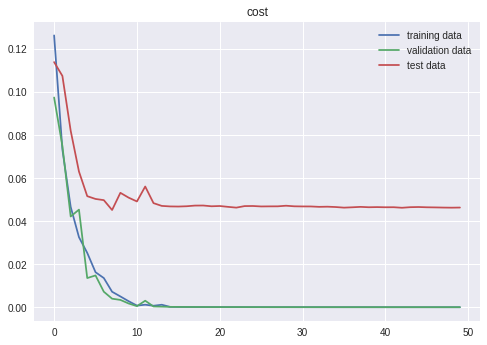

In [13]:
plt.figure()
plt.plot(lst_epochs, lst_train_cost, label='training data')
plt.plot(lst_epochs, lst_valid_cost, label='validation data')
plt.plot(lst_epochs, lst_test_cost, label='test data')
plt.title('cost')
plt.legend()

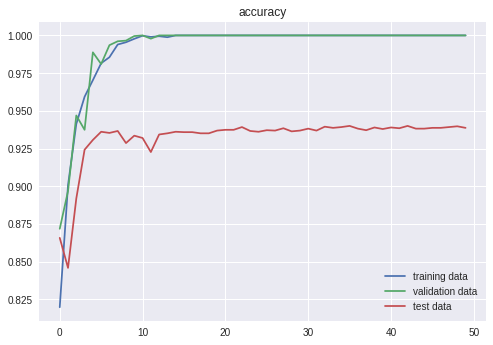

In [14]:
plt.figure()
plt.plot(lst_epochs, lst_train_acc, label='training data')
plt.plot(lst_epochs, lst_valid_acc, label='validation data')
plt.plot(lst_epochs, lst_test_acc, label='test data')
plt.title('accuracy')
plt.legend()

### Receiver operating characteristic

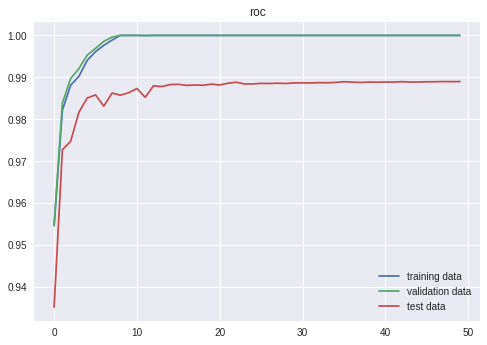

In [15]:
plt.figure()
plt.plot(lst_epochs, lst_train_roc, label='training data')
plt.plot(lst_epochs, lst_valid_roc, label='validation data')
plt.plot(lst_epochs, lst_test_roc, label='test data')
plt.title('roc')
plt.legend()
plt.show()

### Learning rate

In [16]:
# new model, new inititialisation of weights.
model_apple = get_model_apple_simple()

lst_epochs = []
lst_lr = []
lst_train_cost = []
lst_valid_cost = []

epochs = 100

for i in range(epochs):
    print('EPOCH', i, '/', epochs)
  
    lr = 1e-5*10.**(i/10)    # going from lr = 1e-5 till 1e+5 
  
    print('lr = ', lr)
       
    model_apple.compile(loss='mse',
                optimizer=sgd(lr), # setting the learning rate
                metrics=['accuracy'])
    
    hist = model_apple.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
              batch_size=32, epochs=1, verbose=1)

    lst_epochs.append(i)
    lst_lr.append(lr)
    lst_train_cost.append(hist.history['loss'])
    lst_valid_cost.append(hist.history['val_loss'])


EPOCH 0 / 100
lr =  1e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.2650 - acc: 0.2913 - val_loss: 0.2646 - val_acc: 0.3021
EPOCH 1 / 100
lr =  1.2589254117941673e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.2643 - acc: 0.2996 - val_loss: 0.2637 - val_acc: 0.3138
EPOCH 2 / 100
lr =  1.5848931924611138e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.2633 - acc: 0.3133 - val_loss: 0.2627 - val_acc: 0.3172
EPOCH 3 / 100
lr =  1.9952623149688796e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.2623 - acc: 0.3356 - val_loss: 0.2615 - val_acc: 0.3751
EPOCH 4 / 100
lr =  2.5118864315095805e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 

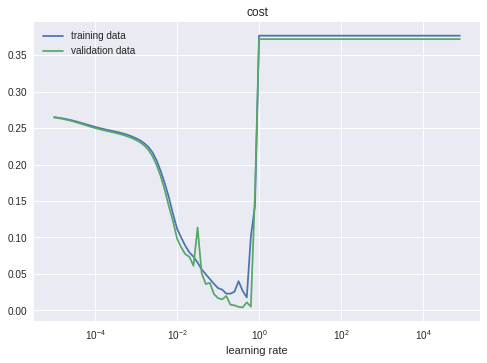

In [0]:
plt.figure()
plt.plot(lst_lr, lst_train_cost, label='training data')
plt.plot(lst_lr, lst_valid_cost, label='validation data')

plt.xlabel('learning rate')
plt.xscale('log')
plt.title('cost')
plt.legend()

In [0]:
model_apple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
average_pooling2d_6 (Average (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
average_pooling2d_7 (Average (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 16)          4112      
__________

## Fruit classifcation

In [28]:
# to impliment

def get_model_fruit_simple(lr=1e-3):
  
    
  model = get_model_base_simple()
  
  # single class classification
  model.add(Dense(17, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer=sgd(lr),
                metrics=['accuracy'])
  
  return model

model_fruit = get_model_fruit_simple(lr=1e-3)

model_fruit.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 11, 11, 16)        0         
_________________________________________________________________
con

In [29]:
def test_performance():
  score = model_fruit.evaluate(x_test, y_test, verbose=0)

  y_test_pred = model_fruit.predict(x_test)
  roc_test = roc_auc_score(y_test, y_test_pred)

  print('TEST - cost:', score[0], ', acc: ', score[1],',roc: ', roc_test)
  
  return score[0], score[1], roc_test
  
lst_epochs = []
lst_train_cost = []
lst_valid_cost = []
lst_test_cost = []
lst_train_acc = []
lst_valid_acc = []
lst_test_acc = []
lst_train_roc = []
lst_valid_roc = []
lst_test_roc = []

epochs = 50
for i in range(epochs):
  print('EPOCH', i, '/', epochs)
  
  hist = model_fruit.fit(x_train, y_train, validation_data=(x_valid, y_valid),
            batch_size=32, epochs=1, verbose=1)
    
  y_train_pred = model_fruit.predict(x_train)
  y_valid_pred = model_fruit.predict(x_valid)
  
  roc_train = roc_auc_score(y_train, y_train_pred)
  roc_valid = roc_auc_score(y_valid, y_valid_pred)
  print('TRAIN - roc: ', roc_train, '| VALID - roc', roc_valid)
  
  test_cost, test_acc, roc_test = test_performance()
  
  lst_epochs.append(i)
  lst_train_cost.append(hist.history['loss'])
  lst_valid_cost.append(hist.history['val_loss'])
  lst_test_cost.append(test_cost)
  lst_train_acc.append(hist.history['acc'])
  lst_valid_acc.append(hist.history['val_acc'])
  lst_test_acc.append(test_acc)
  lst_train_roc.append(roc_train)
  lst_valid_roc.append(roc_valid)
  lst_test_roc.append(roc_test)

EPOCH 0 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 2.3965 - acc: 0.3507 - val_loss: 2.3101 - val_acc: 0.3720
TRAIN - roc:  0.620695547143403 | VALID - roc 0.6176634540105067
TEST - cost: 2.310940565050558 , acc:  0.37574347039048356 ,roc:  0.6037782181026791
EPOCH 1 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 2.2810 - acc: 0.3768 - val_loss: 2.2721 - val_acc: 0.3720
TRAIN - roc:  0.6475991658843531 | VALID - roc 0.6452094159090414
TEST - cost: 2.2750393426291913 , acc:  0.37574347039048356 ,roc:  0.629870836382302
EPOCH 2 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 2.2399 - acc: 0.3768 - val_loss: 2.2277 - val_acc: 0.3720
TRAIN - roc:  0.6847039349997199 | VALID - roc 0.6833253586153669
TEST - cost: 2.2326846935350146 , acc:  0.37574347039048356 ,roc:  0.660588754

In [0]:
model_fruit.save('fruit.h5')

files.download('fruit.h5')

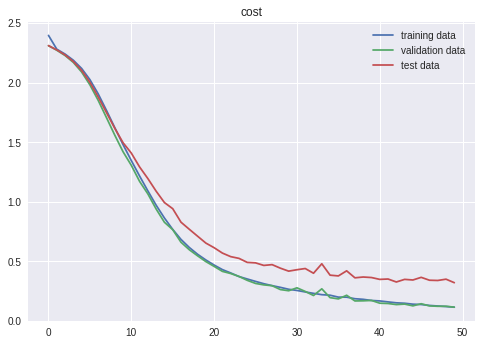

In [30]:
plt.figure()
plt.plot(lst_epochs, lst_train_cost, label='training data')
plt.plot(lst_epochs, lst_valid_cost, label='validation data')
plt.plot(lst_epochs, lst_test_cost, label='test data')
plt.title('cost')
plt.legend()

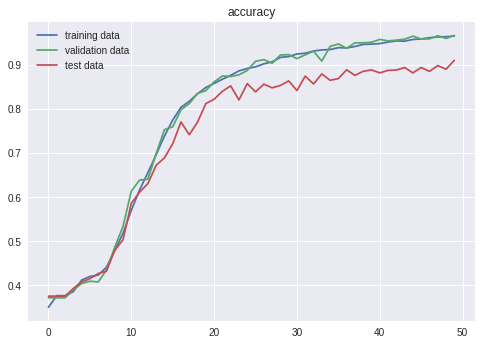

In [31]:
plt.figure()
plt.plot(lst_epochs, lst_train_acc, label='training data')
plt.plot(lst_epochs, lst_valid_acc, label='validation data')
plt.plot(lst_epochs, lst_test_acc, label='test data')
plt.title('accuracy')
plt.legend()

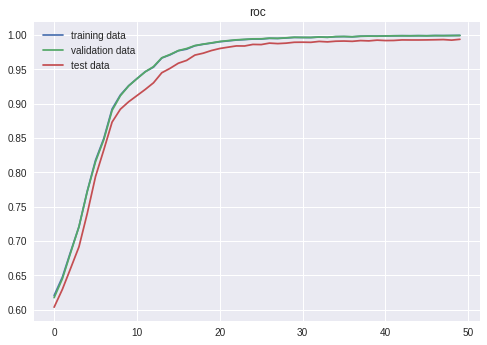

In [32]:
plt.figure()
plt.plot(lst_epochs, lst_train_roc, label='training data')
plt.plot(lst_epochs, lst_valid_roc, label='validation data')
plt.plot(lst_epochs, lst_test_roc, label='test data')
plt.title('roc')
plt.legend()
plt.show()

In [33]:
# Question 4

# new model, new inititialisation of weights.
model_fruit = get_model_fruit_simple()

lst_epochs = []
lst_lr = []
lst_train_cost = []
lst_valid_cost = []

epochs = 100

for i in range(epochs):
    print('EPOCH', i, '/', epochs)
  
    lr = 1e-5*10.**(i/10)    # going from lr = 1e-5 till 1e+5 
  
    print('lr = ', lr)
       
    model_fruit.compile(loss='mse',
                optimizer=sgd(lr), # setting the learning rate
                metrics=['accuracy'])
    
    hist = model_fruit.fit(x_train, y_train, validation_data=(x_valid, y_valid),
              batch_size=32, epochs=1, verbose=1)

    lst_epochs.append(i)
    lst_lr.append(lr)
    lst_train_cost.append(hist.history['loss'])
    lst_valid_cost.append(hist.history['val_loss'])


EPOCH 0 / 100
lr =  1e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.0558 - acc: 0.0420 - val_loss: 0.0558 - val_acc: 0.0445
EPOCH 1 / 100
lr =  1.2589254117941673e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.0558 - acc: 0.0420 - val_loss: 0.0558 - val_acc: 0.0445
EPOCH 2 / 100
lr =  1.5848931924611138e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.0558 - acc: 0.0420 - val_loss: 0.0558 - val_acc: 0.0445
EPOCH 3 / 100
lr =  1.9952623149688796e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.0558 - acc: 0.0420 - val_loss: 0.0558 - val_acc: 0.0445
EPOCH 4 / 100
lr =  2.5118864315095805e-05
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 

In [0]:
plt.figure()
plt.plot(lst_lr, lst_train_cost, label='training data')
plt.plot(lst_lr, lst_valid_cost, label='validation data')

plt.xlabel('learning rate')
plt.xscale('log')
plt.title('cost')
plt.legend()

In [0]:
model_fruit.summary()

In [0]:
#Confusion Matrix
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

In [0]:
# Question 5


def get_model_base_simple_q5():  
  model = Sequential()
  
  k = 16
  model.add(InputLayer((100, 100, 3)))
  model.add(AveragePooling2D(pool_size=(2, 2))) # downsampling
  model.add(Conv2D(k, (3, 3), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Conv2D(k, (3, 3), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Conv2D(k, (4, 4), activation='elu'))
  model.add(AveragePooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  #model.add(Dense(3, activation='elu'))
  model.add(Dense(50, activation='elu'))
  
  return model

def get_model_apple_simple_q5(lr=1e-3):
  
  model = get_model_base_simple_q5()
  # single class classification
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='mse',
                optimizer=sgd(lr),
                metrics=['accuracy'])
  
  return model

In [0]:
model_q5 = get_model_apple_simple_q5(lr=1e-1)

model_q5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
average_pooling2d_21 (Averag (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 16)        2320      
_________________________________________________________________
average_pooling2d_23 (Averag (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 16)          4112      
__________

In [0]:
def test_performance():
  score = model_q5.evaluate(x_test, y_test_apple, verbose=0)

  y_test_pred = model_q5.predict(x_test)
  roc_test = roc_auc_score(y_test_apple, y_test_pred)

  print('TEST - cost:', score[0], ', acc: ', score[1],',roc: ', roc_test)
  
  return score[0], score[1], roc_test
  
lst_epochs = []
lst_train_cost = []
lst_valid_cost = []
lst_test_cost = []
lst_train_acc = []
lst_valid_acc = []
lst_test_acc = []
lst_train_roc = []
lst_valid_roc = []
lst_test_roc = []

epochs = 50
for i in range(epochs):
  print('EPOCH', i, '/', epochs)
  
  hist = model_q5.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
            batch_size=32, epochs=1, verbose=1)
    
  y_train_pred = model_q5.predict(x_train)
  y_valid_pred = model_q5.predict(x_valid)
  
  roc_train = roc_auc_score(y_train_apple, y_train_pred)
  roc_valid = roc_auc_score(y_valid_apple, y_valid_pred)
  print('TRAIN - roc: ', roc_train, '| VALID - roc', roc_valid)
  
  test_cost, test_acc, roc_test = test_performance()
  
  lst_epochs.append(i)
  lst_train_cost.append(hist.history['loss'])
  lst_valid_cost.append(hist.history['val_loss'])
  lst_test_cost.append(test_cost)
  lst_train_acc.append(hist.history['acc'])
  lst_valid_acc.append(hist.history['val_acc'])
  lst_test_acc.append(test_acc)
  lst_train_roc.append(roc_train)
  lst_valid_roc.append(roc_valid)
  lst_test_roc.append(roc_test)

EPOCH 0 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 6s - loss: 0.1193 - acc: 0.8290 - val_loss: 0.1391 - val_acc: 0.7833
TRAIN - roc:  0.9565959579553422 | VALID - roc 0.9590036756205101
TEST - cost: 0.1594911072832736 , acc:  0.7439875872769589 ,roc:  0.9440853452360656
EPOCH 1 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.0705 - acc: 0.9059 - val_loss: 0.0714 - val_acc: 0.9046
TRAIN - roc:  0.9781876778897868 | VALID - roc 0.9800336466779885
TEST - cost: 0.08017533837557281 , acc:  0.9058701836048616 ,roc:  0.9703883802389252
EPOCH 2 / 50
Train on 9268 samples, validate on 2317 samples
Epoch 1/1
9268/9268 [==============================] - 4s - loss: 0.0471 - acc: 0.9427 - val_loss: 0.0286 - val_acc: 0.9646
TRAIN - roc:  0.9896685350052197 | VALID - roc 0.991312459635946
TEST - cost: 0.05021652976194618 , acc:  0.9260408585466771 ,roc:  0.98111868

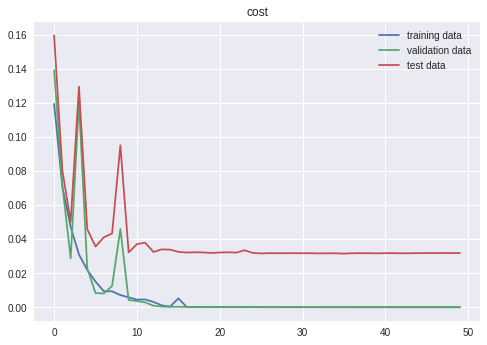

In [0]:
#cost
plt.figure()
plt.plot(lst_epochs, lst_train_cost, label='training data')
plt.plot(lst_epochs, lst_valid_cost, label='validation data')
plt.plot(lst_epochs, lst_test_cost, label='test data')
plt.title('cost')
plt.legend()

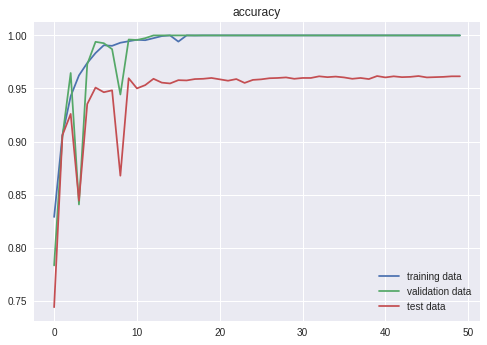

In [0]:
#accuracy
plt.figure()
plt.plot(lst_epochs, lst_train_acc, label='training data')
plt.plot(lst_epochs, lst_valid_acc, label='validation data')
plt.plot(lst_epochs, lst_test_acc, label='test data')
plt.title('accuracy')
plt.legend()

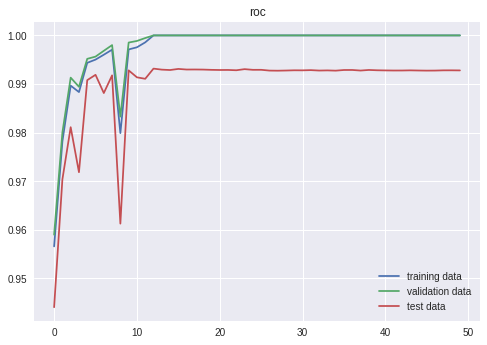

In [0]:
#roc
plt.figure()
plt.plot(lst_epochs, lst_train_roc, label='training data')
plt.plot(lst_epochs, lst_valid_roc, label='validation data')
plt.plot(lst_epochs, lst_test_roc, label='test data')
plt.title('roc')
plt.legend()
plt.show()

# Testing on own data

In [0]:
files.upload()

In [0]:
def open_image(path):
  
  img = plt.imread(path)
  
  plt.figure()
  plt.imshow(img)
  
  # TODO preprocessing 
  ...
  
  resize = cv2.resize(img, (100, 100))
  single_x = np.stack([resize])
  
  return single_x


single_x = open_image('<your_fruit.jpg>')

model_apple = load_model('apple.h5')
model_fruit = load_model('fruit.h5')

pred_apple = model_apple.predict(single_x)
pred_fruit = model_fruit.predict(single_x)